In [1]:
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from keras.layers import LSTM, Dense,Input,Layer
from keras import backend as K,Model
from numpy.random import seed
from imblearn.under_sampling import RandomUnderSampler 
seed(0)
import os
os.environ['PYTHONHASHSEED']=str(0)
import tensorflow as tf
tf.random.set_seed(0)
import random
import random as python_random
python_random.seed(0)
random.seed(0)

In [2]:
data = pd.read_csv('creditcard.csv', na_filter=True)

data.drop(['Time'], axis=1, inplace=True)
selected_vars =['V4','V14','V10','V16','V9','V12','V11','V17','V7','V21','V18','V8','V1','V3','V6','V2','V27','V5','V26','Class']


In [3]:
tr_data = data[selected_vars]
tr_data.shape

(284807, 20)

In [4]:
X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']

In [5]:
y=tr_data['Class']

In [6]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
X=pd.DataFrame(StandardScaler().fit_transform(X))

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, shuffle=False,random_state=0)
from sklearn.linear_model import SGDOneClassSVM
df1_normal=X_train[y_train==0]
clf = SGDOneClassSVM(nu=0.01,random_state=0)
res = clf.fit_predict(df1_normal)
print(len(res[res==-1]))
res[res==1] = 0
res[res==-1] = 1
ros = RandomUnderSampler(sampling_strategy=0.95)
ros.fit_resample(df1_normal,res)
index=ros.sample_indices_
X_train.drop(X_train.index[index], inplace=True)
y_train.drop(y_train.index[index], inplace=True)

2155


In [8]:
X_train.shape

(194941, 19)

In [9]:
X_test.shape

(85443, 19)

In [10]:
# X_train et X_test sont des dataframe qui contient les features
train_LSTM_X=X_train.to_numpy()
test_LSTM_X=X_test.to_numpy()
train_LSTM_y=y_train.to_numpy()
test_LSTM_y=y_test.to_numpy()
w=3
X_train=np.zeros([train_LSTM_X.shape[0]-w+1,w, train_LSTM_X.shape[1]])
for i in range(train_LSTM_X.shape[0]-w+1):
    for j in range(w):
        X_train[i][j]=train_LSTM_X[i+j]
X_test=np.zeros([test_LSTM_X.shape[0]-w+1,w, test_LSTM_X.shape[1]])
for i in range(test_LSTM_X.shape[0]-w+1):
    for j in range(w):
        X_test[i][j]=test_LSTM_X[i+j]
## Recuperation des labels

y_train=np.delete(train_LSTM_y,[*range(0, w-1, 1)], 0)
y_test=np.delete(test_LSTM_y,[*range(0, w-1, 1)], 0)


In [11]:
inputs=Input((w,19))
x1=LSTM(50)(inputs)
outputs=Dense(1,activation='sigmoid')(x1)
model=Model(inputs,outputs)

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision','Recall'])

In [13]:
history1=model.fit(X_train, y_train,epochs=10,batch_size=500,validation_data=(X_test, y_test))

Epoch 1/10
390/390 [==============================] - 10s 13ms/step - loss: 0.0843 - precision: 0.0297 - recall: 0.2798 - val_loss: 0.0045 - val_precision: 1.0000 - val_recall: 0.3333
Epoch 2/10
390/390 [==============================] - 5s 14ms/step - loss: 0.0042 - precision: 0.8493 - recall: 0.6399 - val_loss: 0.0032 - val_precision: 0.9714 - val_recall: 0.6296
Epoch 3/10
390/390 [==============================] - 6s 15ms/step - loss: 0.0036 - precision: 0.8628 - recall: 0.7839 - val_loss: 0.0028 - val_precision: 0.9610 - val_recall: 0.6852
Epoch 4/10
390/390 [==============================] - 6s 16ms/step - loss: 0.0033 - precision: 0.8627 - recall: 0.8006 - val_loss: 0.0027 - val_precision: 0.9625 - val_recall: 0.7130
Epoch 5/10
390/390 [==============================] - 6s 16ms/step - loss: 0.0031 - precision: 0.8635 - recall: 0.8061 - val_loss: 0.0026 - val_precision: 0.9630 - val_recall: 0.7222
Epoch 6/10
390/390 [==============================] - 6s 16ms/step - loss: 0.0030 - 

In [14]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]> 0.5

In [15]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_probs)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_probs)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_probs)
print('Recall: %f' % recall)
f1 = f1_score(y_test, yhat_probs)
print('f1: %f' % f1)

Accuracy: 0.999661
Precision: 0.975904
Recall: 0.750000
f1: 0.848168


In [16]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [17]:
cm = confusion_matrix(y_true=y_test, y_pred=yhat_probs)

In [18]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = ['Normal','Fraud']

Confusion matrix, without normalization
[[85331     2]
 [   27    81]]


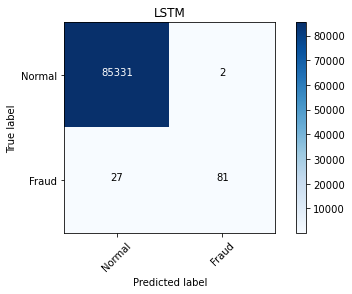

In [19]:
plot_confusion_matrix(cm=cm, classes=labels, title='LSTM')